## First pass attempt to run Mountainsort using spikeinterfaces
The data used for this purpose is on continuously sampled wideband data collected by Jimmie Gmaz. [(Source)](http://datasets.datalad.org/?dir=/labs/mvdm/BiconditionalOdor)

In [1]:
# Recommended import aliases: https://spikeinterface.readthedocs.io/en/latest/getting_started/plot_getting_started.html
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
# Additional imports
import os.path as op
import neo  # neo for some direct reading to check on # of segments etc
import numpy as np
import matplotlib.pyplot as plt
import os

08:52:28 [I] klustakwik KlustaKwik2 version 0.2.6


In [2]:
# sample_file can be any file in the directory which has ALL the ncs files.
sample_file = 'data/BiconditionalOdor/M040-2020-04-29-CDOD12/CSC14.ncs'
dname = (op.dirname(sample_file))
# print(dname)
# Throws an error if the the ncs files don't have the same length
# On omitting the file with a different length, this works (data/BiconditionalOdor/M040-2020-04-28-CDOD11/CSC26.ncs for instance)
reader = neo.NeuralynxIO(dirname=dname)
print(reader)

NeuralynxIO: data/BiconditionalOdor/M040-2020-04-29-CDOD12
nb_block: 1
nb_segment:  [5]
signal_channels: [CSC10, CSC11, CSC12, CSC13 ... CSC30 CSC31 CSC32 CSC9]
unit_channels: [chTT3#13#0, chTT3#14#0, chTT3#8#0, chTT3#24#0 ... chTT8#3#0 chTT8#4#0 chTT8#19#0 chTT8#20#0]
event_channels: [Events event_id=11 ttl=0, Events event_id=11 ttl=1, Events event_id=11 ttl=2, Events event_id=11 ttl=4 ... Events event_id=11 ttl=48 Events event_id=11 ttl=64 Events event_id=11 ttl=96 Events event_id=19 ttl=0]



**NOTE:** The following section with the Python gymnastics (or hacks) can be entirely skipped if a probe geometry file is present in the directory, along with all the channel mappings

In [3]:
# These are ordered dictionary from which we can extract the CSC/TT to AD channels mapping
# Ideally these should be present in the promoted dataset or should be more cleanly extracted 
print(reader.nse_ntt_filenames,"\n")
print(reader.ncs_filenames,"\n")

OrderedDict([(('TT3', 13), 'data/BiconditionalOdor/M040-2020-04-29-CDOD12/M040-2020-04-29-TT3.ntt'), (('TT3', 14), 'data/BiconditionalOdor/M040-2020-04-29-CDOD12/M040-2020-04-29-TT3.ntt'), (('TT3', 8), 'data/BiconditionalOdor/M040-2020-04-29-CDOD12/M040-2020-04-29-TT3.ntt'), (('TT3', 24), 'data/BiconditionalOdor/M040-2020-04-29-CDOD12/M040-2020-04-29-TT3.ntt'), (('TT4', 31), 'data/BiconditionalOdor/M040-2020-04-29-CDOD12/M040-2020-04-29-TT4.ntt'), (('TT4', 15), 'data/BiconditionalOdor/M040-2020-04-29-CDOD12/M040-2020-04-29-TT4.ntt'), (('TT4', 9), 'data/BiconditionalOdor/M040-2020-04-29-CDOD12/M040-2020-04-29-TT4.ntt'), (('TT4', 25), 'data/BiconditionalOdor/M040-2020-04-29-CDOD12/M040-2020-04-29-TT4.ntt'), (('TT5', 23), 'data/BiconditionalOdor/M040-2020-04-29-CDOD12/M040-2020-04-29-TT5.ntt'), (('TT5', 7), 'data/BiconditionalOdor/M040-2020-04-29-CDOD12/M040-2020-04-29-TT5.ntt'), (('TT5', 1), 'data/BiconditionalOdor/M040-2020-04-29-CDOD12/M040-2020-04-29-TT5.ntt'), (('TT5', 2), 'data/Bico

In [4]:
# Creating an AD channel to CSC file mapping
ntt_channel_id_name = {}
for key,value in reader.nse_ntt_filenames:
    ntt_channel_id_name[value] = key
# print(ntt_channel_id_name)

In [5]:
# Creating AD channel to TT and TT to AD channel mapping
ncs_channel_name_id = {}
ncs_channel_id_name = {}
for key,value in reader.ncs_filenames:
    ncs_channel_name_id[key] = value
    ncs_channel_id_name[value] = key
# print(ncs_channel_name_id)
# print(ncs_channel_id_name)

In [6]:
# Creating TT to CSC mapping, to be used for creating 'channel groups' later
ntt_ncs_map = {}
for key in ntt_channel_id_name.keys():
    if ntt_channel_id_name[key] in ntt_ncs_map:
        ntt_ncs_map[ntt_channel_id_name[key]].append(ncs_channel_id_name[key])
    else:
        ntt_ncs_map[ntt_channel_id_name[key]] = []
        ntt_ncs_map[ntt_channel_id_name[key]].append(ncs_channel_id_name[key])
# print (ntt_ncs_map)

In [7]:
recordingList = [se.NeuralynxRecordingExtractor(dirname=op.dirname(sample_file), seg_index=i) for i in range(reader.segment_count(0))]

# This concatenates mutiple segments together
recordingFull = se.MultiRecordingTimeExtractor(recordingList)

<table><tr>
<td> <img src="ks2_test/A4x2-tet-CM42-channelMap.png" alt="Drawing"/> </td>
<td> <img src="ks2_test/A4x2-tet-CM42-probeGeometry.png" alt="Drawing"/> </td>
</tr></table>

## Location generation Code
Based on the images above, I generate positions for the various channels

In [8]:
# The keys refer to the contact ids as referred in the above images
# The CSC names were based on these contact names, so that reduces the need to define yet another mapping.
location_keys_1 = [6,1,8,3];
location_keys_2 = [5,2,7,4];
seed1 = np.array([0, 0])
seed2 = np.array([0,150])
x_offset = np.array([200,0])
location_values_1 = [seed1, seed1+([-25/np.sqrt(2),25/np.sqrt(2)]), seed1+np.array([25/np.sqrt(2),25/np.sqrt(2)]), seed1+np.array([0,50/np.sqrt(2)])]
location_values_2 = [seed2, seed2+([-25/np.sqrt(2),25/np.sqrt(2)]), seed2+np.array([25/np.sqrt(2),25/np.sqrt(2)]), seed2+np.array([0,50/np.sqrt(2)])]
for i in range(3):
    location_keys_1.extend([location_keys_1[j]+8*(i+1) for j in range(4)])
    location_values_1.extend(location_values_1[j]+x_offset*(i+1) for j in range(4))
    location_keys_2.extend([location_keys_2[j]+8*(i+1) for j in range(4)])
    location_values_2.extend(location_values_2[j]+x_offset*(i+1) for j in range(4))
# print (location_keys_1)
# print (location_keys_2)
location_name_keys = location_keys_1 + location_keys_2
location_name_keys = ['CSC'+str(x) for x in location_name_keys]
location_values = location_values_1 + location_values_2
# print(location_name_keys, location_values)
location_dict = {}
for i in range(len(location_name_keys)):
    location_dict[location_name_keys[i]] = location_values[i]
# print(location_dict)

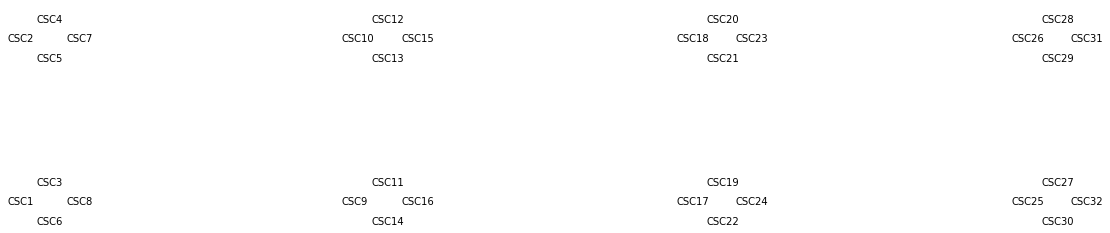

In [9]:
# Sanity check to see that the relative locations of the various channels match that of the images above
xcoords = [pos[0] for pos in location_values]
ycoords = [pos[1] for pos in location_values]
fig,ax = plt.subplots()
ax.axis('off')
for i in range(len(xcoords)):
    plt.text(xcoords[i]/200,ycoords[i]/200,location_name_keys[i])


In [10]:
# These channel ids reflect the AD-channels (I don't know if this is specific to Neuralynx Extractor or not, 
# but I guess not because I extracted the mapping before even calling the Neuralynx extractor). Therefore we use the
# mappings obtained earlier to assign locations and groups correctly
channel_ids = recordingFull.get_channel_ids()

# Set channel groups based on the CSC-TT mapping, could be changed to CSC-shank or whatever else is suitable later
group_ids = [int(ntt_channel_id_name[channel_ids[i]][2:]) for i in range(len(channel_ids))]
# print(group_ids)
recordingFull.set_channel_groups(group_ids)
# Set channel locations from the ones generated above
channel_locs = np.array([location_dict[ncs_channel_id_name[channel_ids[i]]] for i in range(len(channel_ids))])
# print (channel_locs)
recordingFull.set_channel_locations(channel_locs)

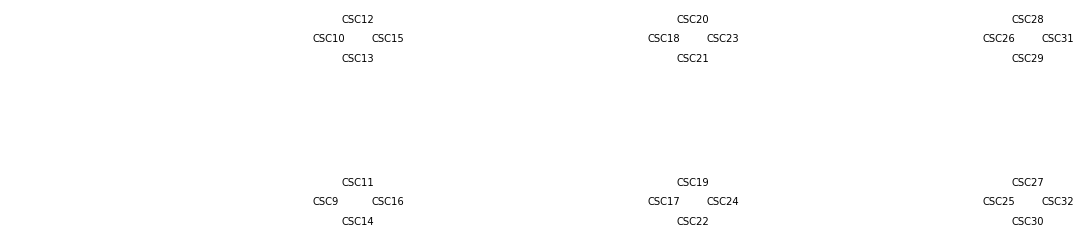

In [11]:
# Sanity check to see if the correct locations have been assigned
# In this case the first shank TT1 and TT2 were not used for the recording, so the assignment looks fine
xcoords = [pos[0] for pos in channel_locs]
ycoords = [pos[1] for pos in channel_locs]
fig,ax = plt.subplots()
ax.axis('off')
for i in range(len(xcoords)):
    plt.text(xcoords[i]/200,ycoords[i]/200,ncs_channel_id_name[channel_ids[i]])

In [12]:
# This should contain mountainsort
print (ss.available_sorters())

['hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'klusta', 'mountainsort4', 'spykingcircus', 'tridesclous', 'waveclus']


In [13]:
# These params should be changed and passed on kwargs if needed
ms4_params = ss.Mountainsort4Sorter.default_params()
ms4_params

{'detect_sign': -1,
 'adjacency_radius': -1,
 'freq_min': 300,
 'freq_max': 6000,
 'filter': True,
 'whiten': True,
 'curation': False,
 'num_workers': None,
 'clip_size': 50,
 'detect_threshold': 3,
 'detect_interval': 10,
 'noise_overlap_threshold': 0.15}

In [14]:
ms4_params['freq_min'] = None
ms4_params['freq_max'] = None

In [15]:
ss.Mountainsort4Sorter.installation_mesg

'\nTo use Mountainsort4 run:\n\n       >>> pip install ml_ms4alg\n\n    More information on mountainsort at:\n      * https://github.com/flatironinstitute/mountainsort\n    '

In [16]:
# Mountainsort won't run if this is False
ss.Mountainsort4Sorter.installed

True

In [17]:
ms4_out = ss.run_mountainsort4(recordingFull, output_folder = 'mountainsort4_test', **ms4_params, verbose=True)

WARNING! The recording contains several group. In order to spike sort by 'group' use grouping_property='group' as argument.
Skipping field: only int or float can be serialized
Skipping field: only int or float can be serialized
Using 4 workers.
Using tmpdir: /tmp/tmp4plt8n_8
Num. workers = 4
Preparing /tmp/tmp4plt8n_8/timeseries.hdf5...
'end_frame' set to 184450560
Preparing neighborhood sorters (M=24, N=184450560)...
Neighboorhood of channel 0 has 24 channels.
Neighboorhood of channel 2 has 24 channels.
Neighboorhood of channel 4 has 24 channels.
Neighboorhood of channel 6 has 24 channels.
Detecting events on channel 1 (phase1)...
Detecting events on channel 5 (phase1)...
Detecting events on channel 3 (phase1)...
Detecting events on channel 7 (phase1)...
Elapsed time for detect on neighborhood: 0:02:04.492247
Elapsed time for detect on neighborhood: 0:02:04.494329
Elapsed time for detect on neighborhood: 0:02:04.493255
Elapsed time for detect on neighborhood: 0:02:04.491523
Num events